In [1]:
%matplotlib inline


# Visualization of Watson-Crick base pairs

This script displays the adenine-thymine and guanine-cytosine base
pairs, taken from an actual DNA 3D structure.


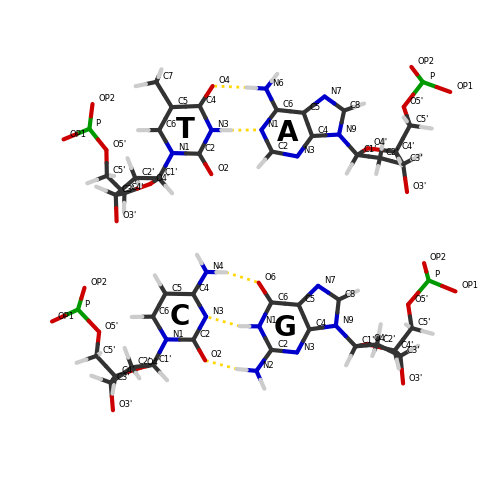

In [2]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import biotite.structure as struc
import biotite.structure.io.mmtf as mmtf
import biotite.structure.graphics as graphics
import biotite.database.rcsb as rcsb


# Structure of a DNA double helix
mmtf_file = mmtf.MMTFFile.read(rcsb.fetch("1qxb", "mmtf"))
structure = mmtf.get_structure(mmtf_file, model=1, include_bonds=True)
nucleotides = structure[struc.filter_nucleotides(structure)]

# Choose one adenine-thymine and one guanine-cytosine base pair
base_pairs = struc.base_pairs(nucleotides)
for i, j in base_pairs:
    if (nucleotides.res_name[i], nucleotides.res_name[j]) == ("DG", "DC"):
        guanine, cytosine = [nucleotides[mask] for mask
                             in struc.get_residue_masks(nucleotides, [i, j])]
        break
for i, j in base_pairs:
    if (nucleotides.res_name[i], nucleotides.res_name[j]) == ("DA", "DT"):
        adenine, thymine = [nucleotides[mask] for mask
                            in struc.get_residue_masks(nucleotides, [i, j])]
        break
pairs = [(guanine, cytosine), (adenine, thymine)]

fig = plt.figure(figsize=(5.0, 5.0))
ax = fig.add_subplot(111, projection="3d")

# Arrange bases
for i, (purine, pyrimidine) in enumerate(pairs):
    n1, n3, c5, c6 = [pyrimidine[pyrimidine.atom_name == name][0]
                      for name in ("N1", "N3", "C5", "C6")]
    # Pyrimidine N3-C6 axis is aligned to x-axis
    purine, pyrimidine = [
        struc.align_vectors(
            base,
            n3.coord - c6.coord,
            np.array([1, 0, 0])
        ) for base in (purine, pyrimidine)
    ]
    # Coords are changed -> update 'Atom' objects
    n1, n3, c4, c5 = [pyrimidine[pyrimidine.atom_name == name][0]
                      for name in ("N1", "N3", "C4", "C5")]
    # Pyrimidine base plane normal vector is aligned to z-axis
    # Furthermore, distance between bases is set
    purine, pyrimidine = [
        struc.align_vectors(
            base,
            np.cross(n3.coord - n1.coord, c5.coord - n1.coord),
            np.array([0, 0, 1]),
            origin_position = struc.centroid(purine + pyrimidine),
            # 10 Å separation between pairs
            target_position = np.array([0, 10*i, 0])
        ) for base in (purine, pyrimidine)
    ]
    pairs[i] = (purine, pyrimidine)

# Plot base pairs
# Merge bases into a single atom array
atoms = pairs[0][0] + pairs[0][1] + pairs[1][0] + pairs[1][1]
# Color by element
colors = np.zeros((atoms.array_length(), 3))
colors[atoms.element == "H"] = (0.8, 0.8, 0.8) # gray
colors[atoms.element == "C"] = (0.2, 0.2, 0.2) # darkgray
colors[atoms.element == "N"] = (0.0, 0.0, 0.8) # blue
colors[atoms.element == "O"] = (0.8, 0.0, 0.0) # red
colors[atoms.element == "P"] = (0.0, 0.6, 0.0) # green
graphics.plot_atoms(
    ax, atoms, colors, line_width=3, background_color="white", zoom=1.5
)

# Plot hydrogen bonds
for purine, pyrimidine in pairs:
    pair = purine + pyrimidine
    bonds = struc.hbond(pair)
    for donor, hydrogen, acceptor in bonds:
        hydrogen_coord = pair.coord[hydrogen]
        acceptor_coord = pair.coord[acceptor]
        x, y, z = zip(hydrogen_coord, acceptor_coord)
        ax.plot(x, y, z, linestyle=":", color="gold", linewidth=2)

# Label heavy atoms
heavy_atoms = atoms[atoms.element != "H"]
for name, coord in zip(heavy_atoms.atom_name, heavy_atoms.coord):
    coord = coord + [0.3, 0.15, 0]
    ax.text(*coord, name, fontsize="6")

# Label bases
for pair in pairs:
    for base in pair:
        label = base.res_name[0][1]
        ring_center = struc.centroid(base[
            np.isin(base.atom_name, ["N1", "C2", "N3", "C4", "C5", "C6"])
        ])
        x, y, z = ring_center
        ax.text(
            x, y, z, label,
            fontsize=20, fontweight="bold", va="center", ha="center"
        )

fig.tight_layout()
plt.show()